# Use Gaussian Processes to model $a_0$ variability

$a_0$ is calculated by optimizing the variable-coefficient KdV equation under a range of stratification conditions.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV


import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

In [3]:
# Load the pre-computed data
csvfile = '../data/ekdv_Prelude_results.csv'

data = pd.read_csv(csvfile, sep=',', parse_dates=['time','timemax'], index_col='time')

data.head()

,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5,a0,Ls,alpha,C
time,,,,,,,,,,,,
2016-05-01,2016-05-01 22:49:00,-17.517,1023.464,1.281,59.462,25.583,83.175,44.421,13.2348,141013.7572,-0.0090,1.5329
2016-05-02,2016-05-02 17:26:00,-16.563,1023.489,1.281,59.431,27.549,84.906,47.735,13.2975,143267.6647,-0.0087,1.5246
2016-05-03,2016-05-03 20:50:00,19.584,1023.489,1.281,59.800,26.636,84.889,50.688,15.8858,116052.2453,-0.0089,1.5188
2016-05-04,2016-05-04 23:28:00,25.726,1023.505,1.283,59.814,27.861,86.798,53.998,17.0912,109527.4289,-0.0087,1.5119
2016-05-05,2016-05-05 18:50:00,-26.879,1023.528,1.282,60.298,29.466,86.836,56.151,17.3610,108830.8088,-0.0086,1.5088


<IPython.core.display.Javascript object>


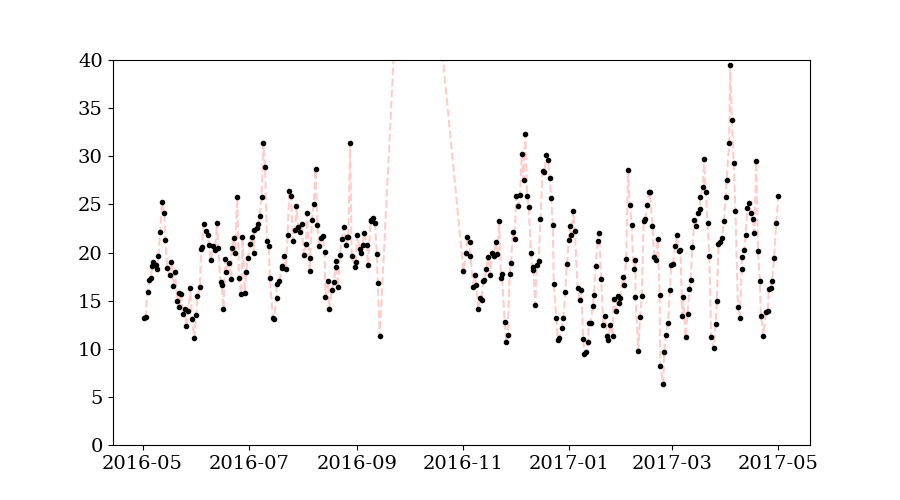

(0, 40)

In [4]:
plt.figure(figsize=(9,5))
#plt.plot(data.index, np.array(a0),'r')
#plt.plot(data.index, np.array(a0),'k.')
plt.plot(data.timemax, data.a0,'r--',alpha=0.2)
plt.plot(data.timemax, data.a0,'k.')

plt.ylim(0,40)

In [ ]:

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode=0
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two
A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan
a0.loc['2016-09-18':'2016-10-31']=np.nan

# Create a time series of single days with the max amplitude and a guess at beta
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)
basetime = datetime(2016,1,1)

a0_harmonic = a0.sel(timeslow=data.index, method='nearest')
tdays_a0 = SecondsSince(a0_harmonic.timeslow.values,basetime=basetime)/86400.

plt.figure(figsize=(9,5))
plt.plot(a0_harmonic.timeslow.values, a0_harmonic,'r--',alpha=0.2)
plt.plot(a0_harmonic.timeslow.values, a0_harmonic,'k.',alpha=0.2)



In [8]:
def sine_model_pm(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0] + beta_s[1]*t
    for ii in range(0,n):
        result += beta_s[2*ii+2]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+3]*pm.math.sin(ff[ii]*t)

    return result

def sine_model_notrend_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+2]*pm.math.sin(ff[ii]*t)

    return result
    
def cosine_model_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t - beta_s[2*ii+2])

    return result

def sine_model_notrend(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0] + 0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result    

class SineModel(pm.gp.mean.Mean):
    def __init__(self, betas, omega):
        self.betas = betas
        self.omega = omega
    def __call__(self, X):
        return tt.squeeze(sine_model_notrend_pm(self.betas, self.omega, X))

<IPython.core.display.Javascript object>


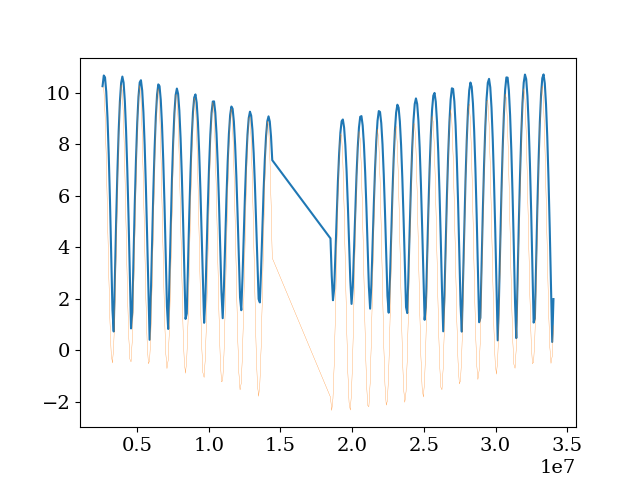

In [9]:
# optimization approach
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)

# optimization approach
def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)
    #return np.abs(result +1j*result_i)
    
class SineModelEnvelope(pm.gp.mean.Mean):
    def __init__(self, betas, omega):
        self.betas = betas
        self.omega = omega
    def __call__(self, X):
        return tt.squeeze(sine_model_envelope_pm(self.betas, self.omega, X))

# Compute a test signal
time = data.index
#time = pd.date_range(data.index[0],data.index[-1],freq='0.25H')
X = data.a0
frqnames = ['M2','S2','K1']
basetime=datetime(2016,4,1)
dtime = np.array(SecondsSince(time, basetime=basetime ))
frq,names = getTideFreq(frqnames)

beta_test = [5,-2.1,4,1.8,0.7,0.6]
beta_test2 = [0,5,-2.1,4,1.8,0.7,0.6]
Xtest = sine_model_envelope(beta_test, frq, dtime)
plt.figure()
plt.plot(dtime, Xtest )
#plt.plot(dtime, np.abs(signal.hilbert(sine_model_notrend(beta_test, frq, dtime))) )
plt.plot(dtime, sine_model_notrend(beta_test2, frq, dtime),lw=0.2)




Elemwise{abs_,no_inplace}.0

In [162]:
# GP Implementation
def harmonic_gp_mcmc(dtime, X, frqnames, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    #dtime = SecondsSince(time, basetime=basetime )
    
    frq,names = getTideFreq(frqnames)

    
    #dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega)# + 1
    
    nt = X.shape[0]
    
    print('Number of Parametrs: %d, nt: %d\n'%(n_params,nt), omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        #beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        #beta_s=[beta_mean]
        beta_s = []
        
        # Use the lstsq as priors
        #mu_re = amp*np.cos(phs)
        #mu_im = amp*np.sin(phs)

        # Harmonics
        for n in range(0,2*len(omega),2):
            #beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=mu_re[n//2], sd = 1.))
            #beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=mu_im[n//2], sd = 1.))
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1, sd = 3.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1, sd = 3.))

        
        # GP
        #ℓ = BoundNormal("ℓ", mu=10000,sd=10000)
        #ℓ = pm.Gamma("ℓ", alpha=0.1,beta=0.5)
        ℓ = pm.HalfNormal("ℓ", sd=1.)

        #T = pm.Gamma("T", alpha=1.,beta=2.)
        #η = pm.HalfCauchy("η", beta=1.)
        η = pm.HalfNormal("η", sd=1.)

        #cov = η**2 * pm.gp.cov.Periodic(1, T, ls=ℓ)
        cov = η**2. * pm.gp.cov.Matern52(1, ℓ)
        
        sigma = pm.HalfCauchy("sigma", beta=10.0)
        
        # Marginal GP implementation
        #gp= pm.gp.Marginal(cov_func=cov, ) # No mean
        gp= pm.gp.Marginal(cov_func=cov, mean_func=SineModelEnvelope(beta_s, omega))
        y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, noise=sigma)
        
        # Latent GP implementation
        #gp = pm.gp.Latent(cov_func=cov, mean_func=SineModelEnvelope(beta_s, omega))
        #f = gp.prior("f", X=dtime[:,None],shape=(nt,))
        #X_obs = pm.Normal('X_obs', mu=f, sd=sigma, observed=X)
        
        #sigma = 1.0
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        
        trace = pm.sample(500, tune=1500, start = start, step=step, cores=2,)
        #                 )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
        
    # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    #trace = None
    #params = None
    
    # Return the trace and the parameter stats
    return trace, params, my_model, gp, mp
    

In [153]:
# Create a function with similar functionality as harmonic_fit in soda
def harmonic_fit_mcmc(dtime, X, frqnames, tune=1000):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    
    frq,names = getTideFreq(frqnames)

    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        #beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[]

        # Harmonics
        for n in range(0,2*len(omega),2):
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1., sd = 10.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1., sd = 10.))
        #for n in range(0,len(omega)):
        #    beta_s.append(BoundNormal('beta_amp_%d'%n,mu=1., sd=10.))
        #    #beta_s.append(pm.Uniform('beta_amp_%d'%n,lower=0, upper=30))
        #    beta_s.append(pm.Uniform('beta_phs_%d'%n, lower=-np.pi, upper=np.pi))

        ###
        # Generate the likelihood function using the deterministic variable as the mean
        #mu_x = cosine_model_pm(beta_s, omega, dtime)
        #mu_x = pm.Deterministic('mu_x', cosine_model_pm(beta_s, omega, dtime))
        mu_x = sine_model_envelope_pm(beta_s, omega, dtime)

        
        #sigma = BoundNormal('sigma', mu=1.,sd=0.25)
        sigma = pm.HalfNormal('sigma',sd=5.)
        
        #sigma = 1.0
        X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=tune, start = start, step=step, cores=2,
                         )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
    
   # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    
    # Return the trace and the parameter stats
    return trace, params, my_model, None, mp

In [168]:
#a_sd = data.a0.std()
#a_mu = data.a0.mean()
#a0 = (data.a0 - a_mu) / a_sd
#a0 = data.a0.values
#idx = a0<50.0

#tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']
#tidecons = ['M2','S2','N2','K2','MA2','MB2']
tidecons = ['M2','S2','N2','K2','K1','O1']
#tidecons = ['M2','S2',]
a0 = a0_harmonic.values
#a_sd = np.std(a0raw)
#a_mu = np.mean(a0raw)
#a0 = (a0raw - a_mu) / a_sd
timein = a0_harmonic.timeslow.values
# Convert the time to days
basetime = datetime(2016,4,1)
#dtime = shared(SecondsSince(timein, basetime=basetime ))
dtime = SecondsSince(timein, basetime=basetime ) / 86400.


#trace, params, my_model, gp, mp = harmonic_gp_mcmc(dtime, a0,tidecons, tune=2000)
trace, params, my_model, gp, mp = harmonic_fit_mcmc(dtime, a0,tidecons, tune=3000)

Number of Parametrs: 13
 [12.14083317674681, 12.566370614359172, 11.912806035637455, 12.600776206127932, 6.300388082120014, 5.8404450946267925]


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,008.9, ||grad|| = 0.10592: 100%|██████████| 46/46 [00:00<00:00, 1108.44it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'beta_0_re': array(-1.20969587), 'beta_0_im': array(-0.35068164), 'beta_1_re': array(-0.06911837), 'beta_1_im': array(0.1115436), 'beta_2_re': array(11.26961503), 'beta_2_im': array(8.45263636), 'beta_3_re': array(0.6594737), 'beta_3_im': array(-0.29721819), 'beta_4_re': array(0.42408804), 'beta_4_im': array(0.5435019), 'beta_5_re': array(-1.66217026), 'beta_5_im': array(-0.12174934), 'sigma_log__': array(1.61091319), 'sigma': array(5.00738183)}


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_5_im, beta_5_re, beta_4_im, beta_4_re, beta_3_im, beta_3_re, beta_2_im, beta_2_re, beta_1_im, beta_1_re, beta_0_im, beta_0_re]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:44<00:00, 34.65draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [169]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0_re,-0.347164,2.942108,0.211981,-4.427656,4.334538,82.540010,0.999080
beta_0_im,0.530982,2.730914,0.199858,-4.071747,4.507944,78.050288,1.000644
beta_1_re,1.510824,7.171379,0.544218,-12.879504,14.197349,83.226837,1.015782
beta_1_im,0.228919,7.436931,0.502207,-13.329350,13.931873,105.972635,0.999337
beta_2_re,0.054593,0.492179,0.025531,-0.868437,1.024366,118.213972,0.999404
beta_2_im,-0.061816,0.463896,0.025803,-0.964452,0.837584,124.412106,1.000462
beta_3_re,-0.067857,2.878101,0.208332,-5.529158,5.518096,70.347307,1.005634
beta_3_im,0.435770,2.720581,0.200239,-5.184926,5.542795,39.421837,1.006674
beta_4_re,0.672323,6.098497,0.462306,-10.498257,12.741678,24.965069,1.021532
beta_4_im,-0.299632,6.005822,0.446903,-11.559799,12.152843,108.284356,1.001859


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


<IPython.core.display.Javascript object>


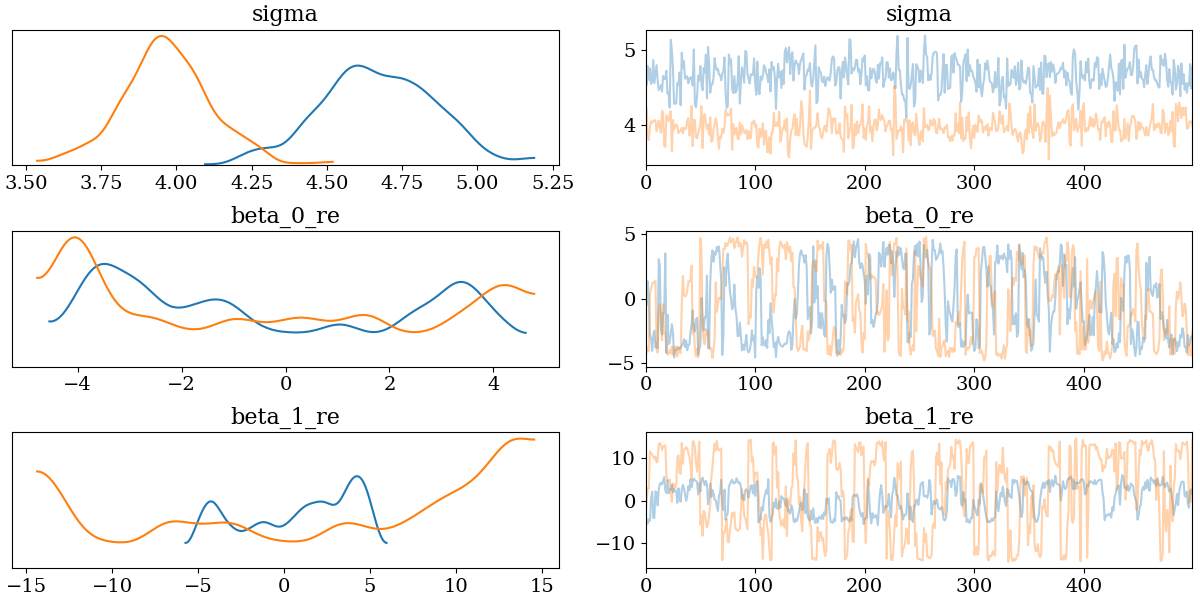

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b42e1f3c8>,
      dtype=object)

In [170]:
pm.traceplot(trace, [
    #'ℓ2',
    #'ℓ',
    #'η',
    'sigma',
    'beta_0_re',
    'beta_1_re',
    ])

In [171]:
# Predict with the MCMC sampler
#tnew = rhotime
#tsecnew = SecondsSince(tnew,basetime=basetime)
#tdaynew = tsecnew/86400.

# Use the built-in function for prediction
nsamples = 1000
#tdays.set_value(tdaynew)
ppc = pm.sample_posterior_predictive(trace, model=my_model, samples=nsamples)

a0_pred = ppc['X_obs']


100%|██████████| 1000/1000 [00:03<00:00, 251.43it/s]


<IPython.core.display.Javascript object>


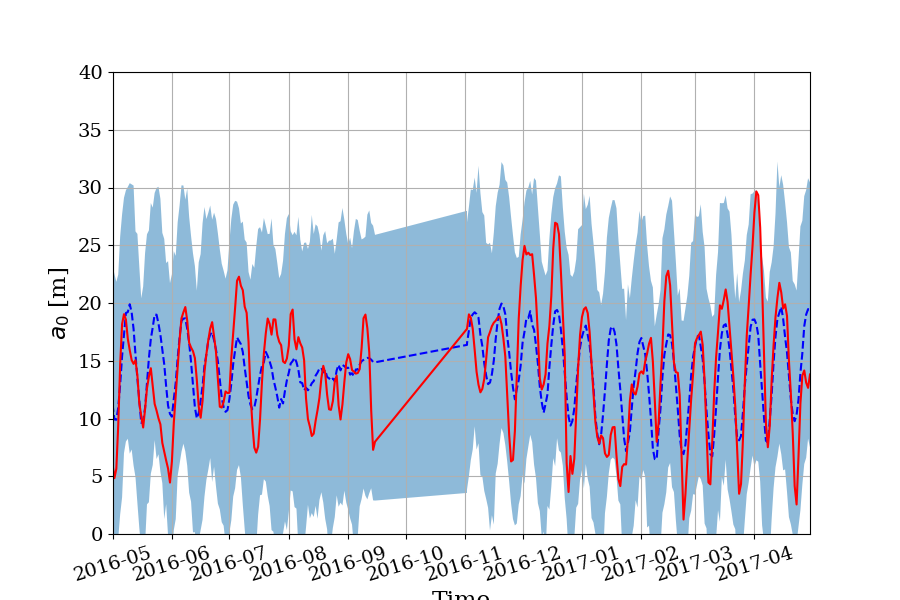

In [172]:
tnew = a0_harmonic.timeslow.values
plt.figure(figsize=(9,6))

p1,=plt.plot(tnew, np.median(a0_pred,axis=0),'b--')

plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
                 np.percentile(a0_pred,99.5,axis=0),alpha=0.5)
#plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                 np.max(a0_pred,axis=0),alpha=0.5)

#p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')
p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r-')



plt.xlim(tnew[0],tnew[-1])
plt.ylim(0,40)
plt.ylabel('$a_0$ [m]')
plt.xlabel('Time')
plt.xticks(rotation=17)
plt.grid(b=True)